## Importing the required libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

C:\Users\niran\Anaconda3\envs\may\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
Using TensorFlow backend.


In [2]:
import os

In [6]:
mylist= os.listdir('Audio_Song_Actors_01-24')

In [7]:
type(mylist)

list

In [9]:
print(mylist[18])

03-02-01-01-01-01-20.wav


In [10]:
print(mylist[400][6:-16])

03


## Plotting the audio file's waveform and its spectrogram

In [11]:
data, sampling_rate = librosa.load('Audio_Song_Actors_01-24/03-02-06-02-02-01-15.wav')

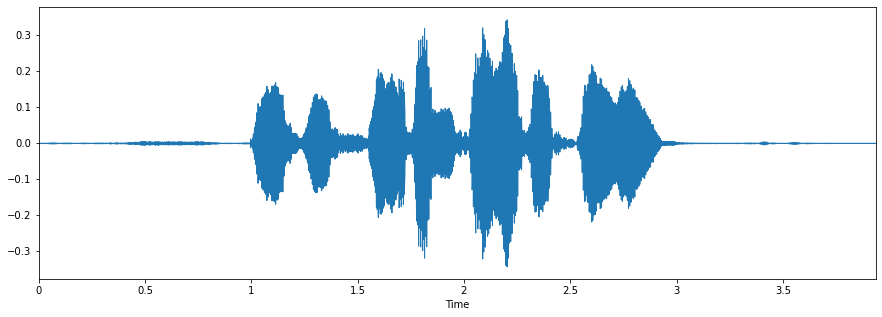

In [13]:
# % pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [17]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import wavio
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('Audio_Song_Actors_01-24/03-02-06-02-02-01-15.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

C:\Users\niran\Anaconda3\envs\may\lib\site-packages\ipykernel_launcher.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  import sys


ValueError: Incomplete wav chunk.

## Setting the labels

In [18]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [20]:
labels = pd.DataFrame(feeling_list)

In [21]:
labels[:10]

,0
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm
5,female_calm
6,male_calm
7,female_calm
8,male_calm
9,female_calm


## Getting the features of audio files using librosa

In [23]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('Audio_Song_Actors_01-24/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [24]:
df[:5]

,feature
0,"[-61.542942, -61.67029, -61.663513, -61.675594..."
1,"[-59.344055, -59.344055, -59.344055, -59.34405..."
2,"[-48.954494, -48.82861, -49.6816, -52.03216, -..."
3,"[-60.07603, -60.313347, -59.857048, -57.80332,..."
4,"[-60.01485, -62.686897, -65.488106, -60.48127,..."


In [25]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [26]:
newdf = pd.concat([df3,labels], axis=1)

In [27]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [28]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-61.542942,-61.670292,-61.663513,-61.675594,-59.627464,-58.578274,-60.384644,-60.370815,-59.209068,-59.793682,...,-32.029648,-28.536741,-27.502647,-26.418858,-27.831207,-28.752033,-28.786449,-21.615858,-17.308699,male_calm
1,-59.344055,-59.344055,-59.344055,-59.344055,-59.344055,-59.344055,-59.344055,-59.344055,-59.344055,-59.344055,...,-42.964802,-43.955097,-44.208008,-43.749870,-42.165371,-43.236343,-43.611912,-20.658558,-12.422130,female_calm
2,-48.954494,-48.828609,-49.681599,-52.032162,-48.399113,-47.975899,-49.650616,-51.260963,-49.758038,-50.975227,...,-23.577650,-24.113667,-22.895826,-22.712572,-24.839592,-27.322344,-28.557560,-28.592690,-25.435741,male_calm
3,-60.076031,-60.313347,-59.857048,-57.803322,-58.947750,-59.264015,-57.992619,-57.401936,-57.059830,-57.166061,...,-42.776798,-40.195335,-38.818481,-39.010696,-41.907330,-42.493778,-43.464279,-36.841316,-29.907366,female_calm
4,-60.014851,-62.686897,-65.488106,-60.481270,-60.038151,-64.788376,-66.386238,-61.152500,-58.949646,-59.597214,...,-43.592575,-42.287838,-42.087948,-42.331047,-40.317867,-37.837944,-35.932858,-32.704998,-28.022449,male_calm


In [29]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
123,-66.509750,-66.509750,-65.822456,-64.809219,-66.102219,-66.087387,-65.922943,-64.785065,-65.326797,-66.509750,...,-35.988800,-35.967766,-35.286049,-35.278831,-34.740929,-33.830132,-34.372265,-27.292450,-21.947689,male_calm
675,-54.954708,-55.314987,-55.057285,-54.872440,-54.372139,-54.192894,-55.845810,-55.657249,-55.506344,-55.612911,...,-17.676435,-18.845058,-20.505796,-19.861799,-18.432095,-18.100405,-19.246204,-17.491056,-13.092523,male_angry
881,-47.044193,-47.289349,-47.470638,-48.799614,-49.333187,-49.770626,-51.110378,-50.408272,-48.978878,-49.951946,...,-43.393440,-43.701225,-43.187355,-42.882408,-41.781040,-40.758301,-40.495689,-26.161119,-17.332867,female_fearful
444,-53.631245,-53.396553,-52.188229,-52.714775,-53.663898,-52.832962,-52.588661,-52.761787,-52.586689,-56.523075,...,-42.393986,-42.583073,-44.382141,-44.495911,-45.511631,-44.837948,-43.241463,-40.181438,-35.077282,female_sad
708,-42.368225,-42.368225,-42.368225,-42.368225,-42.368225,-42.368225,-42.368225,-42.368225,-42.368225,-42.368225,...,-31.699057,-32.587414,-30.132870,-30.099989,-32.439384,-35.606876,-35.007420,-6.784913,1.771483,female_angry
895,-51.863243,-51.863243,-51.863243,-51.863243,-51.863243,-51.863243,-51.863243,-51.863243,-51.863243,-51.863243,...,-24.939270,-24.900156,-24.463625,-23.779470,-23.550243,-23.911640,-23.861238,-16.416420,-12.178488,male_fearful
320,-49.591824,-48.310486,-47.640793,-46.625343,-47.571945,-45.061790,-44.766438,-47.780540,-48.729347,-49.939213,...,-25.188894,-24.044216,-23.870291,-25.385349,-24.725368,-24.086088,-25.574514,-14.032943,-9.047819,male_happy
53,-51.352337,-51.739861,-51.824787,-51.898354,-53.880802,-55.147137,-56.017246,-57.151360,-53.582645,-52.549515,...,-44.520126,-48.110996,-48.306107,-49.382084,-49.741432,-47.963890,-49.856045,-48.339905,-48.574669,female_calm
294,-47.872246,-47.872246,-47.872246,-47.872246,-47.872246,-47.872246,-47.872246,-47.872246,-47.872246,-47.872246,...,-41.040310,-41.931236,-41.863094,-41.289543,-40.327633,-41.391624,-42.071861,-36.798592,-30.512257,female_happy
462,-47.028503,-47.306553,-46.636471,-45.185234,-46.110672,-46.848824,-46.637112,-49.055954,-48.240440,-46.492306,...,-24.329691,-21.944942,-22.006681,-24.828522,-27.322060,-27.433422,-29.647484,-25.831942,-24.255632,male_sad


In [30]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [31]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [32]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
585,-52.608078,-49.516914,-50.374348,-53.096924,-52.763943,-50.902691,-49.895927,-47.445251,-47.316082,-43.325771,...,-23.610821,-24.327301,-24.709219,-27.589947,-26.442131,-26.327812,-25.804108,-19.461014,-14.189299,male_angry
3,-60.076031,-60.313347,-59.857048,-57.803322,-58.947750,-59.264015,-57.992619,-57.401936,-57.059830,-57.166061,...,-42.776798,-40.195335,-38.818481,-39.010696,-41.907330,-42.493778,-43.464279,-36.841316,-29.907366,female_calm
745,-50.002640,-50.114021,-51.335884,-51.368019,-51.357754,-50.199341,-49.533943,-49.755497,-50.893185,-49.808876,...,-37.585426,-39.068604,-39.899551,-38.985703,-39.612740,-41.767555,-42.121475,-23.383146,-16.090076,female_fearful
636,-49.168858,-46.598984,-45.677940,-46.527248,-49.652214,-48.046116,-47.477135,-45.425594,-45.391949,-45.334816,...,-42.416927,-43.439781,-46.734238,-45.012756,-42.766567,-43.993099,-45.036140,-22.641428,-13.785501,female_angry
733,-45.047260,-45.014275,-45.090595,-44.972416,-45.012264,-44.720352,-44.659321,-44.350342,-44.390793,-44.119331,...,-35.444653,-34.365459,-32.823845,-34.002800,-35.127888,-35.148537,-36.351570,-22.161703,-16.037973,female_angry
136,-61.197495,-61.591118,-58.713886,-58.276283,-61.533199,-61.718014,-61.686478,-61.306633,-59.106869,-59.439903,...,-33.732288,-29.556192,-27.134611,-28.124929,-28.885090,-28.086546,-28.274565,-24.938246,-20.766357,male_calm
371,-60.602760,-60.924969,-61.564854,-58.466652,-56.777584,-58.518856,-60.507912,-60.939365,-61.327938,-62.278896,...,-47.085529,-45.905193,-45.820110,-45.183754,-45.501438,-43.343258,-43.069851,-42.566338,-36.447304,female_sad
49,-59.283310,-59.283310,-59.283310,-59.283310,-59.283310,-59.283310,-59.283310,-60.162197,-58.328056,-58.705463,...,-42.280170,-37.908653,-37.050064,-38.493828,-38.409847,-40.297588,-40.275467,-26.389078,-18.184639,female_calm
234,-54.618992,-54.074741,-56.352791,-59.550545,-58.432732,-55.242760,-54.547325,-56.185379,-57.388470,-57.412113,...,-31.968554,-30.679962,-31.553383,-27.987570,-25.827244,-24.439589,-25.158400,-21.805180,-16.859730,male_happy
639,-55.711002,-55.711002,-55.711002,-55.711002,-55.711002,-55.711002,-55.711002,-55.711002,-55.711002,-55.711002,...,-38.372776,-39.288120,-41.244530,-41.955376,-41.237968,-40.284386,-41.162289,-36.426846,-29.188198,female_angry


In [33]:
trainfeatures = train.iloc[:, :-1]

In [34]:
trainlabel = train.iloc[:, -1:]

In [35]:
testfeatures = test.iloc[:, :-1]

In [36]:
testlabel = test.iloc[:, -1:]

In [37]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


C:\Users\niran\Anaconda3\envs\may\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [38]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [39]:
X_train.shape

(746, 216)

## Changing dimension for CNN model

In [40]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [41]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 216, 256)          1536      
_________________________________________________________________
activation_1 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_2 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 27, 128)          

In [43]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [44]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

Train on 746 samples, validate on 174 samples
Epoch 1/700
746/746 [==============================] - 3s 4ms/step - loss: 2.5260 - accuracy: 0.0871 - val_loss: 2.2926 - val_accuracy: 0.0747
Epoch 2/700
746/746 [==============================] - 3s 4ms/step - loss: 2.2797 - accuracy: 0.1206 - val_loss: 2.2542 - val_accuracy: 0.0805
Epoch 3/700
746/746 [==============================] - 3s 4ms/step - loss: 2.2250 - accuracy: 0.1233 - val_loss: 2.2156 - val_accuracy: 0.1954
Epoch 4/700
746/746 [==============================] - 3s 4ms/step - loss: 2.1730 - accuracy: 0.1662 - val_loss: 2.1702 - val_accuracy: 0.1724
Epoch 5/700
746/746 [==============================] - 3s 5ms/step - loss: 2.1340 - accuracy: 0.1810 - val_loss: 2.1469 - val_accuracy: 0.1149
Epoch 6/700
746/746 [==============================] - 3s 4ms/step - loss: 2.1058 - accuracy: 0.1944 - val_loss: 2.0982 - val_accuracy: 0.2069
Epoch 7/700
746/746 [==============================] - 3s 4ms/step - loss: 2.0695 - accuracy: 0.

746/746 [==============================] - 3s 4ms/step - loss: 1.3258 - accuracy: 0.4812 - val_loss: 1.4251 - val_accuracy: 0.3966
Epoch 58/700
746/746 [==============================] - 3s 4ms/step - loss: 1.3253 - accuracy: 0.4853 - val_loss: 1.4111 - val_accuracy: 0.4310
Epoch 59/700
746/746 [==============================] - 3s 4ms/step - loss: 1.3311 - accuracy: 0.4558 - val_loss: 1.3991 - val_accuracy: 0.4885
Epoch 60/700
746/746 [==============================] - 3s 4ms/step - loss: 1.3229 - accuracy: 0.4651 - val_loss: 1.4195 - val_accuracy: 0.4138
Epoch 61/700
746/746 [==============================] - 3s 4ms/step - loss: 1.3134 - accuracy: 0.4786 - val_loss: 1.4327 - val_accuracy: 0.4655
Epoch 62/700
746/746 [==============================] - 3s 4ms/step - loss: 1.3066 - accuracy: 0.4625 - val_loss: 1.4311 - val_accuracy: 0.4310
Epoch 63/700
746/746 [==============================] - 3s 4ms/step - loss: 1.3006 - accuracy: 0.4625 - val_loss: 1.3882 - val_accuracy: 0.4713
Epoch

Epoch 114/700
746/746 [==============================] - 3s 5ms/step - loss: 1.1240 - accuracy: 0.5496 - val_loss: 1.2756 - val_accuracy: 0.4483
Epoch 115/700
746/746 [==============================] - 4s 5ms/step - loss: 1.1169 - accuracy: 0.5670 - val_loss: 1.2524 - val_accuracy: 0.5057
Epoch 116/700
746/746 [==============================] - 4s 5ms/step - loss: 1.1028 - accuracy: 0.5509 - val_loss: 1.2745 - val_accuracy: 0.5000
Epoch 117/700
746/746 [==============================] - 3s 5ms/step - loss: 1.1000 - accuracy: 0.5764 - val_loss: 1.2856 - val_accuracy: 0.4713
Epoch 118/700
746/746 [==============================] - 3s 4ms/step - loss: 1.1078 - accuracy: 0.5483 - val_loss: 1.2772 - val_accuracy: 0.4828
Epoch 119/700
746/746 [==============================] - 3s 5ms/step - loss: 1.1021 - accuracy: 0.5509 - val_loss: 1.3066 - val_accuracy: 0.4425
Epoch 120/700
746/746 [==============================] - 3s 5ms/step - loss: 1.1102 - accuracy: 0.5456 - val_loss: 1.2983 - val_ac

746/746 [==============================] - 3s 5ms/step - loss: 0.9963 - accuracy: 0.6153 - val_loss: 1.2378 - val_accuracy: 0.5057
Epoch 171/700
746/746 [==============================] - 4s 5ms/step - loss: 0.9925 - accuracy: 0.6032 - val_loss: 1.2363 - val_accuracy: 0.5115
Epoch 172/700
746/746 [==============================] - 3s 4ms/step - loss: 0.9853 - accuracy: 0.5992 - val_loss: 1.2341 - val_accuracy: 0.4943
Epoch 173/700
746/746 [==============================] - 3s 5ms/step - loss: 0.9893 - accuracy: 0.6247 - val_loss: 1.2283 - val_accuracy: 0.5000
Epoch 174/700
746/746 [==============================] - 4s 5ms/step - loss: 0.9868 - accuracy: 0.5858 - val_loss: 1.2014 - val_accuracy: 0.4828
Epoch 175/700
746/746 [==============================] - 4s 5ms/step - loss: 0.9730 - accuracy: 0.6153 - val_loss: 1.2474 - val_accuracy: 0.4770
Epoch 176/700
746/746 [==============================] - 3s 5ms/step - loss: 0.9982 - accuracy: 0.6019 - val_loss: 1.2236 - val_accuracy: 0.5057

746/746 [==============================] - 3s 4ms/step - loss: 0.8966 - accuracy: 0.6515 - val_loss: 1.2468 - val_accuracy: 0.4943
Epoch 227/700
746/746 [==============================] - 3s 4ms/step - loss: 0.8981 - accuracy: 0.6408 - val_loss: 1.2827 - val_accuracy: 0.4655
Epoch 228/700
746/746 [==============================] - 3s 5ms/step - loss: 0.9053 - accuracy: 0.6542 - val_loss: 1.2487 - val_accuracy: 0.4943
Epoch 229/700
746/746 [==============================] - 3s 4ms/step - loss: 0.8987 - accuracy: 0.6542 - val_loss: 1.2438 - val_accuracy: 0.4425
Epoch 230/700
746/746 [==============================] - 3s 4ms/step - loss: 0.8991 - accuracy: 0.6622 - val_loss: 1.2259 - val_accuracy: 0.4828
Epoch 231/700
746/746 [==============================] - 3s 4ms/step - loss: 0.8912 - accuracy: 0.6729 - val_loss: 1.2280 - val_accuracy: 0.5057
Epoch 232/700
746/746 [==============================] - 3s 4ms/step - loss: 0.8830 - accuracy: 0.6555 - val_loss: 1.1862 - val_accuracy: 0.5345

746/746 [==============================] - 3s 4ms/step - loss: 0.8154 - accuracy: 0.6836 - val_loss: 1.2121 - val_accuracy: 0.5115
Epoch 283/700
746/746 [==============================] - 3s 4ms/step - loss: 0.8281 - accuracy: 0.6903 - val_loss: 1.1768 - val_accuracy: 0.5000
Epoch 284/700
746/746 [==============================] - 3s 4ms/step - loss: 0.8134 - accuracy: 0.6930 - val_loss: 1.2577 - val_accuracy: 0.4483
Epoch 285/700
746/746 [==============================] - 3s 4ms/step - loss: 0.8150 - accuracy: 0.6836 - val_loss: 1.2059 - val_accuracy: 0.4943
Epoch 286/700
746/746 [==============================] - 3s 4ms/step - loss: 0.8048 - accuracy: 0.6957 - val_loss: 1.2176 - val_accuracy: 0.5000
Epoch 287/700
746/746 [==============================] - 3s 4ms/step - loss: 0.8161 - accuracy: 0.6971 - val_loss: 1.2252 - val_accuracy: 0.5230
Epoch 288/700
746/746 [==============================] - 3s 4ms/step - loss: 0.8074 - accuracy: 0.6957 - val_loss: 1.2310 - val_accuracy: 0.4713

746/746 [==============================] - 3s 4ms/step - loss: 0.7331 - accuracy: 0.7279 - val_loss: 1.1904 - val_accuracy: 0.5345
Epoch 339/700
746/746 [==============================] - 3s 4ms/step - loss: 0.7370 - accuracy: 0.7225 - val_loss: 1.2143 - val_accuracy: 0.5000
Epoch 340/700
746/746 [==============================] - 3s 4ms/step - loss: 0.7407 - accuracy: 0.7332 - val_loss: 1.1839 - val_accuracy: 0.5057
Epoch 341/700
746/746 [==============================] - 3s 4ms/step - loss: 0.7182 - accuracy: 0.7440 - val_loss: 1.2175 - val_accuracy: 0.4713
Epoch 342/700
746/746 [==============================] - 3s 4ms/step - loss: 0.7356 - accuracy: 0.7373 - val_loss: 1.2121 - val_accuracy: 0.5460s: 0.7371 - ac - ETA: 0s - loss: 0.7411 - accuracy: 
Epoch 343/700
746/746 [==============================] - 3s 4ms/step - loss: 0.7319 - accuracy: 0.7359 - val_loss: 1.2208 - val_accuracy: 0.5575
Epoch 344/700
746/746 [==============================] - 3s 4ms/step - loss: 0.7249 - accura

746/746 [==============================] - 3s 4ms/step - loss: 0.6620 - accuracy: 0.7654 - val_loss: 1.2511 - val_accuracy: 0.5345
Epoch 395/700
746/746 [==============================] - 3s 4ms/step - loss: 0.6563 - accuracy: 0.7668 - val_loss: 1.1937 - val_accuracy: 0.5287
Epoch 396/700
746/746 [==============================] - 3s 4ms/step - loss: 0.6623 - accuracy: 0.7507 - val_loss: 1.1914 - val_accuracy: 0.5172
Epoch 397/700
746/746 [==============================] - 3s 4ms/step - loss: 0.6664 - accuracy: 0.7507 - val_loss: 1.1972 - val_accuracy: 0.5115
Epoch 398/700
746/746 [==============================] - 3s 4ms/step - loss: 0.6488 - accuracy: 0.7614 - val_loss: 1.1802 - val_accuracy: 0.5287
Epoch 399/700
746/746 [==============================] - 3s 4ms/step - loss: 0.6523 - accuracy: 0.7480 - val_loss: 1.2011 - val_accuracy: 0.5057
Epoch 400/700
746/746 [==============================] - 3s 4ms/step - loss: 0.6576 - accuracy: 0.7654 - val_loss: 1.2776 - val_accuracy: 0.4655

746/746 [==============================] - 3s 4ms/step - loss: 0.5812 - accuracy: 0.7989 - val_loss: 1.1999 - val_accuracy: 0.5345
Epoch 451/700
746/746 [==============================] - ETA: 0s - loss: 0.5859 - accuracy: 0.80 - 3s 4ms/step - loss: 0.5830 - accuracy: 0.8043 - val_loss: 1.2292 - val_accuracy: 0.5000
Epoch 452/700
746/746 [==============================] - 3s 4ms/step - loss: 0.5906 - accuracy: 0.7828 - val_loss: 1.2047 - val_accuracy: 0.5000
Epoch 453/700
746/746 [==============================] - 3s 4ms/step - loss: 0.5723 - accuracy: 0.8083 - val_loss: 1.3866 - val_accuracy: 0.4540
Epoch 454/700
746/746 [==============================] - 3s 4ms/step - loss: 0.5793 - accuracy: 0.7895 - val_loss: 1.2278 - val_accuracy: 0.5402
Epoch 455/700
746/746 [==============================] - 3s 4ms/step - loss: 0.5813 - accuracy: 0.7855 - val_loss: 1.2324 - val_accuracy: 0.5402
Epoch 456/700
746/746 [==============================] - 3s 4ms/step - loss: 0.5783 - accuracy: 0.8003

746/746 [==============================] - 3s 4ms/step - loss: 0.5166 - accuracy: 0.8190 - val_loss: 1.2333 - val_accuracy: 0.5000
Epoch 507/700
746/746 [==============================] - 3s 4ms/step - loss: 0.5168 - accuracy: 0.8284 - val_loss: 1.2560 - val_accuracy: 0.5000
Epoch 508/700
746/746 [==============================] - 3s 4ms/step - loss: 0.5081 - accuracy: 0.8418 - val_loss: 1.3378 - val_accuracy: 0.4828
Epoch 509/700
746/746 [==============================] - 3s 4ms/step - loss: 0.5048 - accuracy: 0.8418 - val_loss: 1.2119 - val_accuracy: 0.5287
Epoch 510/700
746/746 [==============================] - 3s 4ms/step - loss: 0.5045 - accuracy: 0.8338 - val_loss: 1.2354 - val_accuracy: 0.5172
Epoch 511/700
746/746 [==============================] - 3s 4ms/step - loss: 0.5016 - accuracy: 0.8284 - val_loss: 1.2330 - val_accuracy: 0.5115
Epoch 512/700
746/746 [==============================] - 3s 4ms/step - loss: 0.5039 - accuracy: 0.8378 - val_loss: 1.2641 - val_accuracy: 0.5000

746/746 [==============================] - 3s 4ms/step - loss: 0.4382 - accuracy: 0.8592 - val_loss: 1.5048 - val_accuracy: 0.4483
Epoch 563/700
746/746 [==============================] - 3s 4ms/step - loss: 0.4372 - accuracy: 0.8499 - val_loss: 1.2719 - val_accuracy: 0.5345
Epoch 564/700
746/746 [==============================] - 3s 4ms/step - loss: 0.4403 - accuracy: 0.8458 - val_loss: 1.3965 - val_accuracy: 0.4713
Epoch 565/700
746/746 [==============================] - 3s 4ms/step - loss: 0.4476 - accuracy: 0.8512 - val_loss: 1.2833 - val_accuracy: 0.5287
Epoch 566/700
746/746 [==============================] - 3s 4ms/step - loss: 0.4367 - accuracy: 0.8525 - val_loss: 1.2798 - val_accuracy: 0.5230
Epoch 567/700
746/746 [==============================] - 3s 4ms/step - loss: 0.4404 - accuracy: 0.8646 - val_loss: 1.2910 - val_accuracy: 0.4828
Epoch 568/700
746/746 [==============================] - 3s 4ms/step - loss: 0.4354 - accuracy: 0.8646 - val_loss: 1.3226 - val_accuracy: 0.5287

746/746 [==============================] - 3s 4ms/step - loss: 0.3813 - accuracy: 0.8981 - val_loss: 1.3074 - val_accuracy: 0.5000
Epoch 619/700
746/746 [==============================] - 3s 4ms/step - loss: 0.3675 - accuracy: 0.8941 - val_loss: 1.3830 - val_accuracy: 0.4943
Epoch 620/700
746/746 [==============================] - 3s 4ms/step - loss: 0.3651 - accuracy: 0.8780 - val_loss: 1.3146 - val_accuracy: 0.5000
Epoch 621/700
746/746 [==============================] - 3s 4ms/step - loss: 0.3759 - accuracy: 0.8928 - val_loss: 1.3402 - val_accuracy: 0.5172
Epoch 622/700
746/746 [==============================] - 3s 4ms/step - loss: 0.3807 - accuracy: 0.8794 - val_loss: 1.3374 - val_accuracy: 0.5402
Epoch 623/700
746/746 [==============================] - 3s 4ms/step - loss: 0.3687 - accuracy: 0.8740 - val_loss: 1.3074 - val_accuracy: 0.5057
Epoch 624/700
746/746 [==============================] - 3s 4ms/step - loss: 0.3658 - accuracy: 0.8981 - val_loss: 1.3449 - val_accuracy: 0.5345

746/746 [==============================] - 3s 4ms/step - loss: 0.3087 - accuracy: 0.9115 - val_loss: 1.4700 - val_accuracy: 0.5057
Epoch 675/700
746/746 [==============================] - 3s 4ms/step - loss: 0.3144 - accuracy: 0.9129 - val_loss: 1.3329 - val_accuracy: 0.5287
Epoch 676/700
746/746 [==============================] - 3s 4ms/step - loss: 0.3055 - accuracy: 0.9115 - val_loss: 1.3504 - val_accuracy: 0.5230
Epoch 677/700
746/746 [==============================] - 3s 4ms/step - loss: 0.3113 - accuracy: 0.9129 - val_loss: 1.3559 - val_accuracy: 0.5460
Epoch 678/700
746/746 [==============================] - 3s 4ms/step - loss: 0.3031 - accuracy: 0.9236 - val_loss: 1.3945 - val_accuracy: 0.5230
Epoch 679/700
746/746 [==============================] - 3s 4ms/step - loss: 0.3088 - accuracy: 0.9088 - val_loss: 1.3998 - val_accuracy: 0.5000
Epoch 680/700
746/746 [==============================] - 3s 4ms/step - loss: 0.3001 - accuracy: 0.9021 - val_loss: 1.4619 - val_accuracy: 0.4943

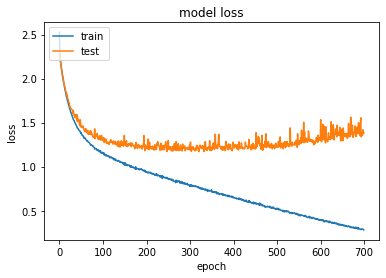

In [45]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [46]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\niran\OneDrive\Desktop\Project_1\Project3_Test\Speech-Emotion-Analyzer\saved_models\Emotion_Voice_Detection_Model.h5 


In [47]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [48]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 56.90%


## Predicting emotions on the test data

In [49]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

174/174 [==============================] - 0s 837us/step


In [50]:
preds

array([[1.7959729e-02, 8.7069750e-01, 5.7607435e-02, ..., 1.5059882e-09,
        7.9698957e-08, 9.8825944e-07],
       [9.9393374e-01, 2.3338059e-06, 5.0824117e-03, ..., 8.0131571e-04,
        7.6434864e-10, 6.6599874e-08],
       [7.9300191e-04, 8.1794106e-08, 6.3181716e-08, ..., 8.2529372e-01,
        1.2009321e-01, 2.0690896e-02],
       ...,
       [7.6109415e-01, 1.3778335e-02, 1.7926528e-01, ..., 7.4362742e-06,
        7.8526837e-06, 5.3586027e-05],
       [1.4799385e-04, 1.4709103e-12, 3.6663247e-10, ..., 5.4231696e-03,
        7.8261690e-03, 3.5130241e-05],
       [3.0906018e-04, 9.6911073e-01, 7.4267527e-03, ..., 8.4677558e-05,
        1.5725852e-06, 1.8616332e-03]], dtype=float32)

In [51]:
preds1=preds.argmax(axis=1)

In [52]:
preds1

array([1, 0, 7, 5, 2, 6, 0, 7, 2, 0, 2, 4, 8, 6, 1, 0, 7, 4, 3, 1, 1, 6,
       5, 6, 7, 4, 5, 7, 4, 3, 7, 3, 7, 1, 2, 5, 3, 3, 2, 3, 5, 4, 9, 3,
       1, 3, 4, 7, 1, 2, 9, 8, 0, 7, 5, 6, 6, 5, 6, 5, 3, 6, 9, 6, 5, 2,
       9, 0, 3, 0, 8, 7, 3, 2, 0, 0, 6, 2, 1, 1, 9, 9, 7, 4, 6, 8, 3, 6,
       1, 7, 8, 6, 4, 2, 9, 6, 9, 6, 3, 3, 1, 3, 2, 0, 7, 4, 5, 9, 7, 6,
       6, 5, 3, 4, 5, 9, 1, 5, 3, 5, 5, 5, 5, 6, 1, 5, 3, 7, 8, 0, 6, 8,
       3, 4, 8, 8, 8, 2, 7, 7, 5, 0, 4, 8, 2, 1, 7, 7, 8, 0, 7, 8, 2, 5,
       5, 7, 7, 3, 9, 3, 4, 7, 8, 9, 0, 7, 3, 6, 0, 0, 9, 0, 5, 1],
      dtype=int64)

In [53]:
abc = preds1.astype(int).flatten()

In [54]:
predictions = (lb.inverse_transform((abc)))

In [55]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,female_calm
1,female_angry
2,male_fearful
3,male_angry
4,female_fearful
5,male_calm
6,female_angry
7,male_fearful
8,female_fearful
9,female_angry


In [56]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [57]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,female_angry
1,female_angry
2,male_sad
3,male_angry
4,female_fearful
5,male_sad
6,female_angry
7,male_angry
8,female_fearful
9,female_fearful


In [58]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [59]:
finaldf[170:180]

,actualvalues,predictedvalues
170,male_sad,male_sad
171,female_fearful,female_angry
172,male_angry,male_angry
173,female_calm,female_calm


In [60]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,20
female_calm,17
female_fearful,17
female_happy,14
female_sad,14
male_angry,23
male_calm,14
male_fearful,16
male_happy,21


In [61]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,17
female_calm,15
female_fearful,14
female_happy,22
female_sad,13
male_angry,22
male_calm,20
male_fearful,24
male_happy,14


In [62]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [88]:
data, sampling_rate = librosa.load('14.wav')

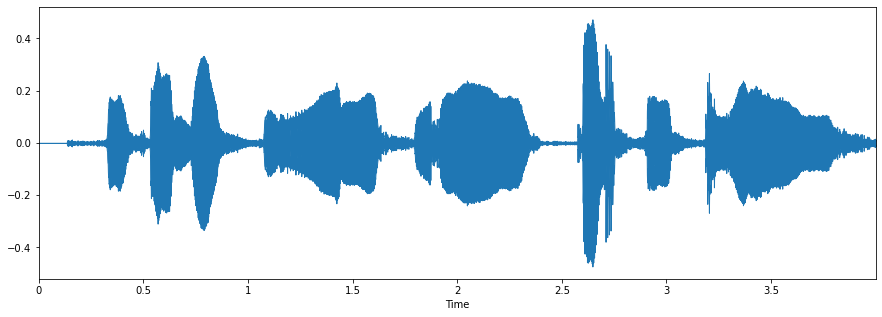

In [89]:
# % pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [100]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('14.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [101]:
livedf2= pd.DataFrame(data=livedf2)

In [102]:
livedf2 = livedf2.stack().to_frame().T

In [103]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-19.0287,-17.235321,-17.130693,-14.276484,-16.29781,-18.208714,-17.485451,-16.065697,-14.752503,-14.033712,...,-11.227779,-8.5263,-11.2081,-14.620745,-13.204439,-15.144588,-16.351946,-16.329029,-11.073838,-4.371945


In [104]:
twodim= np.expand_dims(livedf2, axis=2)

In [105]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 2ms/step


In [106]:
livepreds

array([[2.61741668e-01, 2.17086222e-06, 7.36440241e-01, 1.55930547e-03,
        2.39971268e-04, 1.40450766e-05, 2.83696666e-09, 1.95218627e-06,
        5.90840045e-07, 1.05576376e-07]], dtype=float32)

In [107]:
livepreds1=livepreds.argmax(axis=1)

In [108]:
liveabc = livepreds1.astype(int).flatten()

In [109]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['female_fearful'], dtype=object)